<a href="https://colab.research.google.com/github/hugeinteger/InterFaceGAN/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running make sure GPU usage is enabled.
Runtime->Change runtime type->GPU

In [1]:
!git clone https://github.com/ShenYujun/InterFaceGAN.git InterFaceGAN
import os
os.chdir("InterFaceGAN")

Cloning into 'InterFaceGAN'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 171 (delta 48), reused 153 (delta 36), pack-reused 0
Receiving objects: 100% (171/171), 2.07 MiB | 26.78 MiB/s, done.
Resolving deltas: 100% (48/48), done.


Mount google drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Copy pretrained models from my google drive.</br>
StyleGAN - https://drive.google.com/open?id=1uka3a1noXHAydRPRbknqwKVGODvnmUBX </br>
ProGAN - https://drive.google.com/open?id=0B4qLcYyJmiz0NHFULTdYc05lX0U

In [0]:
# StyleGAN model pre-trained on celebahq dataset
!cp '/gdrive/My Drive/StyleGAN/networks/karras2019stylegan-celebahq-1024x1024.pkl' models/pretrain

# StyleGAN model pre-trained on ffhq dataset
!cp '/gdrive/My Drive/StyleGAN/networks/karras2019stylegan-ffhq-1024x1024.pkl' models/pretrain

# ProGAN model pre-trained on celebahq
!cp '/gdrive/My Drive/ProgressiveGAN/networks/tensorflow-version/karras2018iclr-celebahq-1024x1024.pkl' models/pretrain

Generate images and latent codes.
Below calls could cause CuDNN version errors, but they disappear after re-runs.

In [9]:
#!mkdir data
!rm -rf data/stylegan_celebahq
!python generate_data.py -m stylegan_celebahq -o data/stylegan_celebahq -n 3
!rm -rf data/stylegan_ffhq
!python generate_data.py -m stylegan_ffhq -o data/stylegan_ffhq -n 3
!rm -rf data/pggan_celebahq
!python generate_data.py -m pggan_celebahq -o data/pggan_celebahq -n 3


[2019-09-06 12:27:40,133][INFO] Initializing generator.
[2019-09-06 12:27:40,453][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2019-09-06 12:27:40,781][INFO] Successfully loaded!
[2019-09-06 12:27:40,782][INFO]   `lod` of the loaded model is 0.0.
[2019-09-06 12:27:43,180][INFO] Preparing latent codes.
[2019-09-06 12:27:43,180][INFO]   Sample latent codes randomly.
[2019-09-06 12:27:43,180][INFO] Generating 3 samples.
[2019-09-06 12:27:43,852][INFO] Saving results.
[2019-09-06 12:27:46,589][INFO] Initializing generator.
[2019-09-06 12:27:46,905][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2019-09-06 12:27:47,233][INFO] Successfully loaded!
[2019-09-06 12:27:47,234][INFO]   `lod` of the loaded model is 0.0.
[2019-09-06 12:27:49,637][INFO] Preparing latent codes.
[2019-09-06 12:27:49,637][INFO]   Sample latent codes randomly.
[2019-09-06 12:27:49,637][INFO] Generating 3 samples.
[2019-09-06 12:27:50,168][INFO] Saving results.
[2019-

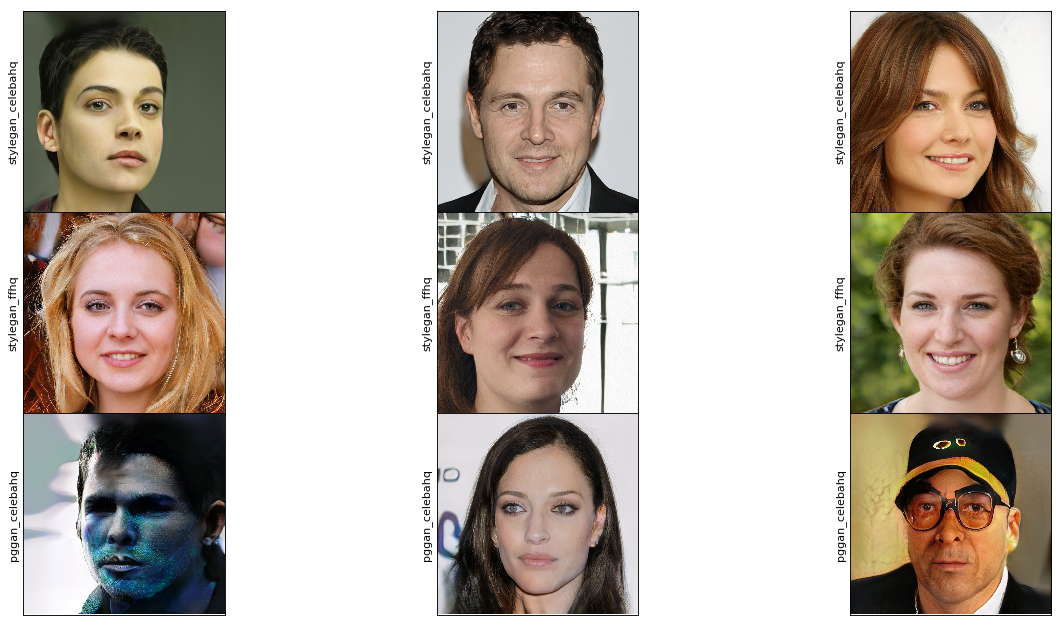

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

plt.figure(figsize=(20, 10), dpi=80)
directory = os.listdir('data')
i = 1
for each in directory:
    currentFolder = 'data/' + each
    for fullpath in glob.glob(currentFolder + "/*.jpg"):
        img=mpimg.imread(fullpath)
        plt.subplot(3, 3, i)
        plt.xticks([])
        plt.yticks([])
        #plt.aspect('equal')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.ylabel(each)
        plt.imshow(img)
        i = i + 1


In [0]:
# Create Figure and Axes instances
fig, ax = plt.subplots(3, 3)

plt.figure(figsize=(20, 10))

directory = os.listdir('data')
i = 0
for each in directory:
    currentFolder = 'data/' + each
    j = 0
    for fullpath in glob.glob(currentFolder + "/*.jpg"):
        img=mpimg.imread(fullpath)
        ax[i, j].set_yticklabels([])
        ax[i, j].set_xticklabels([])
        ax[i, j].imshow(img)
        j = j + 1
    i = i + 1

plt.show()

In [0]:
#!mkdir results
!rm -rf results/stylegan_celebahq_smile_editing
#!python edit.py -h
!python edit.py  -m stylegan_celebahq -b boundaries/stylegan_celebahq_smile_boundary.npy -i data/stylegan_celebahq/z.npy -o results/stylegan_celebahq_smile_editing 

[2019-09-04 13:05:58,228][INFO] Initializing generator.
[2019-09-04 13:05:58,531][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2019-09-04 13:05:58,864][INFO] Successfully loaded!
[2019-09-04 13:05:58,865][INFO]   `lod` of the loaded model is 0.0.
[2019-09-04 13:06:01,371][INFO] Preparing boundary.
[2019-09-04 13:06:01,383][INFO] Preparing latent codes.
[2019-09-04 13:06:01,383][INFO]   Load latent codes from `data/stylegan_celebahq/z.npy`.
[2019-09-04 13:06:01,384][INFO] Editing 10 samples.
[2019-09-04 13:06:18,039][INFO] Successfully edited 10 samples.
